In [1]:
import transformers
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm

from torch import nn, optim
from torch.utils import data

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

import warnings
warnings.filterwarnings('ignore')

## *Считываем данные*

In [2]:
df = pd.read_csv('Data/train.csv')
df_t = pd.read_csv('Data/test.csv')
df.head(5)

,id,text,label
0,0,Как отключить тариф?,FAQ - тарифы и услуги
1,1,тариф,мобильная связь - тарифы
2,2,тариф,мобильная связь - тарифы
3,3,Здрасте я хотел получить золотую карту,FAQ - тарифы и услуги
4,4,Золотую карту,FAQ - тарифы и услуги


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32800 entries, 0 to 32799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      32800 non-null  int64 
 1   text    32709 non-null  object
 2   label   32800 non-null  object
dtypes: int64(1), object(2)
memory usage: 768.9+ KB


In [4]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29002 entries, 0 to 29001
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      29002 non-null  int64 
 1   text    28872 non-null  object
dtypes: int64(1), object(1)
memory usage: 453.3+ KB


In [5]:
df_tmp = df[pd.isnull(df.text)]

In [6]:
df_tmp.label.value_counts()

мобильная связь - тарифы               62
Мобильные услуги                       15
FAQ - интернет                          5
запрос обратной связи                   3
Баланс                                  2
Роуминг                                 2
Мобильный интернет                      1
мобильная связь - зона обслуживания     1
Name: label, dtype: int64

#### *Видно, что в тренировочных данных есть выбросы с пустыми значениями. Но так как в тестовой выборке тоже присутвуют выбросы, их оставляем.*

#### Создадим словари классов от слов к числам и обратно, чтобы дальше было легко менять значения `label`. Пропишем для этого функцию:

In [7]:
def unique(array):
    outList = []
    for word in array:
        if not word in outList:
            outList.append(word)
    
    return [{outList[i]:i for i in range(len(outList))},
            {i:outList[i] for i in range(len(outList))}]

In [8]:
class_to_num, num_to_class = unique(df['label'].values)
class_to_num, num_to_class

({'FAQ - тарифы и услуги': 0,
  'мобильная связь - тарифы': 1,
  'Мобильный интернет': 2,
  'FAQ - интернет': 3,
  'тарифы - подбор': 4,
  'Баланс': 5,
  'Мобильные услуги': 6,
  'Оплата': 7,
  'Личный кабинет': 8,
  'SIM-карта и номер': 9,
  'Роуминг': 10,
  'запрос обратной связи': 11,
  'Устройства': 12,
  'мобильная связь - зона обслуживания': 13},
 {0: 'FAQ - тарифы и услуги',
  1: 'мобильная связь - тарифы',
  2: 'Мобильный интернет',
  3: 'FAQ - интернет',
  4: 'тарифы - подбор',
  5: 'Баланс',
  6: 'Мобильные услуги',
  7: 'Оплата',
  8: 'Личный кабинет',
  9: 'SIM-карта и номер',
  10: 'Роуминг',
  11: 'запрос обратной связи',
  12: 'Устройства',
  13: 'мобильная связь - зона обслуживания'})

#### Сохраним для дальнейшего использования

In [9]:
import json
with open('Dicts/class_to_num.json', 'w') as f:
    json.dump(class_to_num, f)
with open('Dicts/num_to_class.json', 'w') as f:
    json.dump(num_to_class, f)    

#### Посмотрим на распределение классов

In [10]:
df.label = df.label.replace(class_to_num)

Text(0.5, 0, 'text labels')

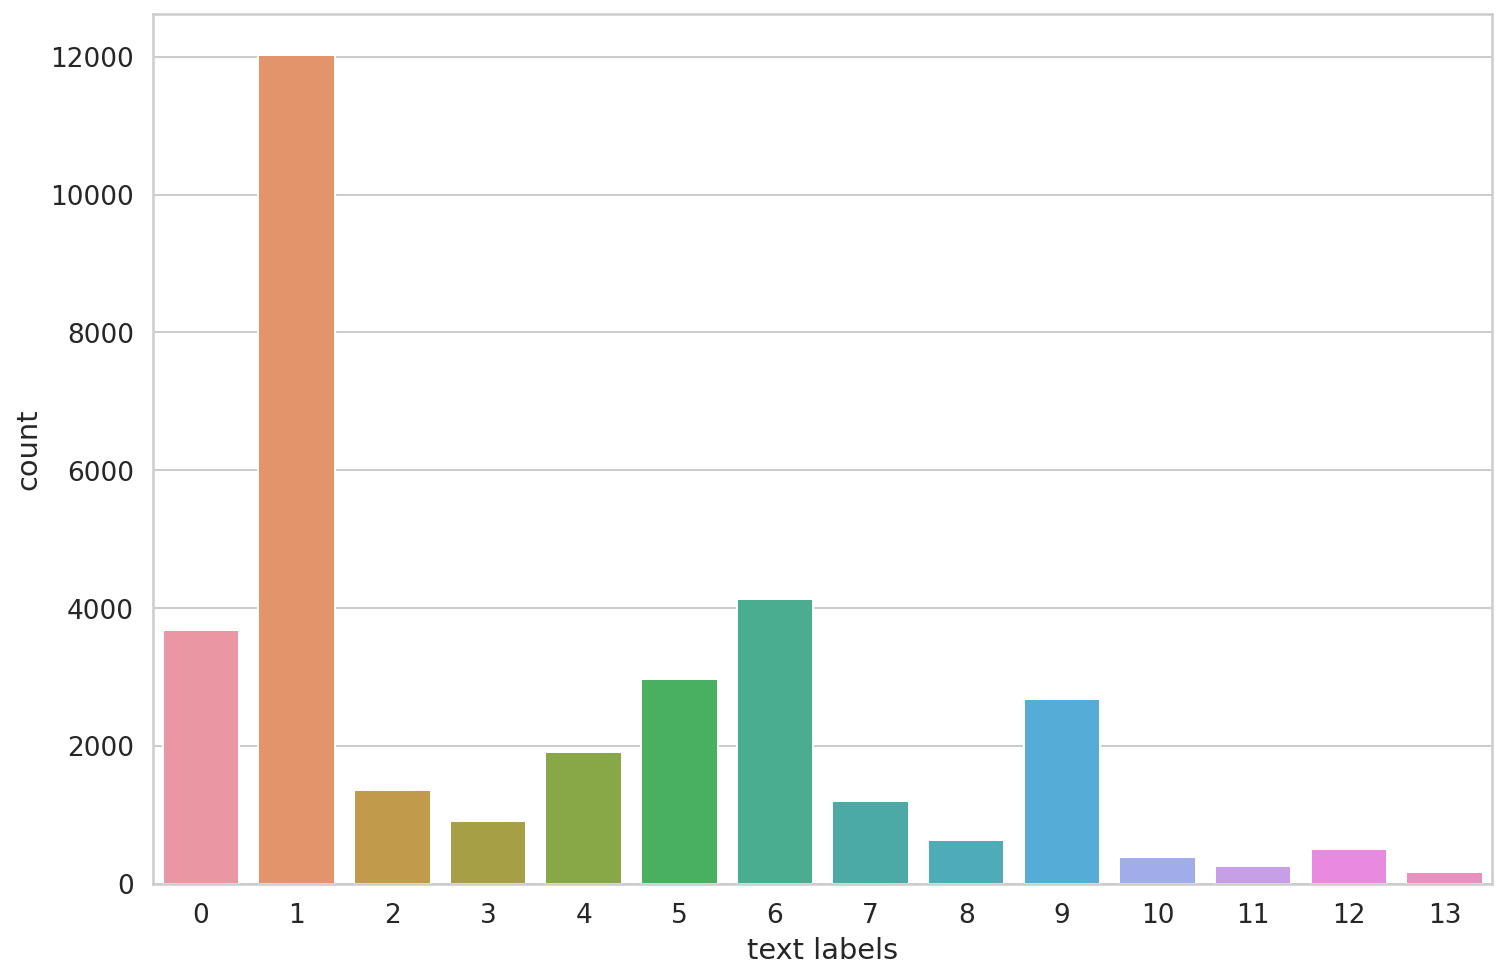

In [11]:
sns.countplot(df.label)
plt.xlabel('text labels')

#### Наша тренировочная выборка несбалансированная, поэтому при обучении модели функцие ошибки присвоим веса классов.
#### Bert принимает массивы из токенов максимальной длиной 512, но наши запросы состоят из одного предложения, поэтому рассчитаем максимальную длину массива токенов для нашей выборки

In [12]:
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
tokens_lens = []
for text in df.text:
    tokens = tokenizer.encode(str(text), truncation=True, max_length=512)
    tokens_lens.append(len(tokens))

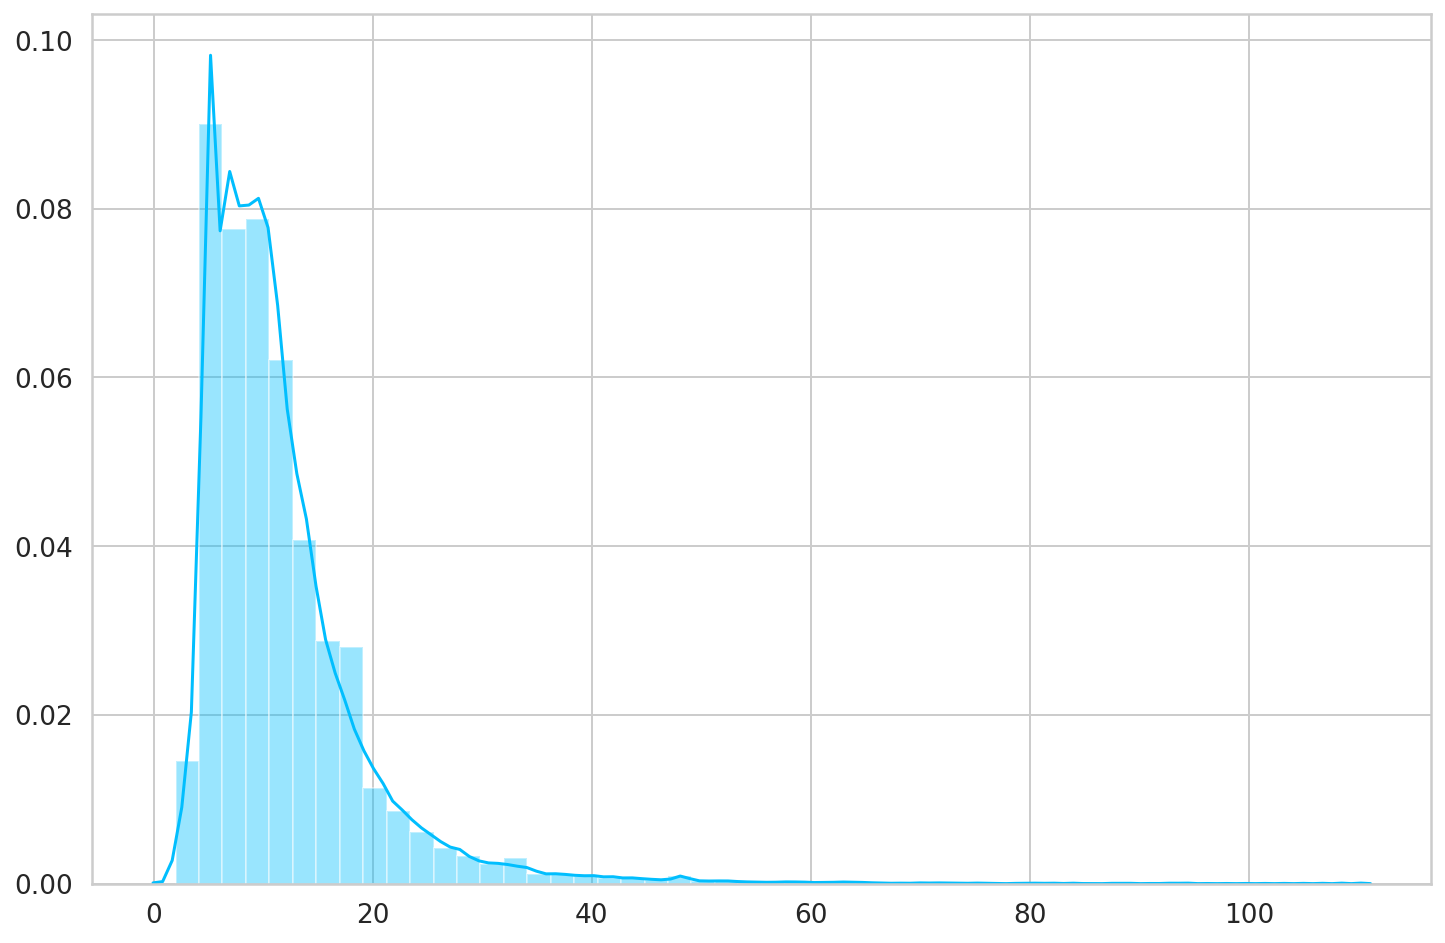

In [14]:
sns.distplot(tokens_lens)

#### Делаем вывод, что 50 токенов нам вполне достаточно

In [15]:
max_len = 50
tokens_new = []
for text in df.text.values:
    encoding = tokenizer.encode_plus(
            str(text),
            max_length=max_len,
            add_special_tokens=True,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
    tokens_new.append(encoding['input_ids'].numpy().tolist()[0])
tokens_new = np.array(tokens_new)

#### Визуализируем наши данные с помощью алгоритма t-SNE

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

In [17]:
X_emb = tsne.fit_transform(tokens_new)

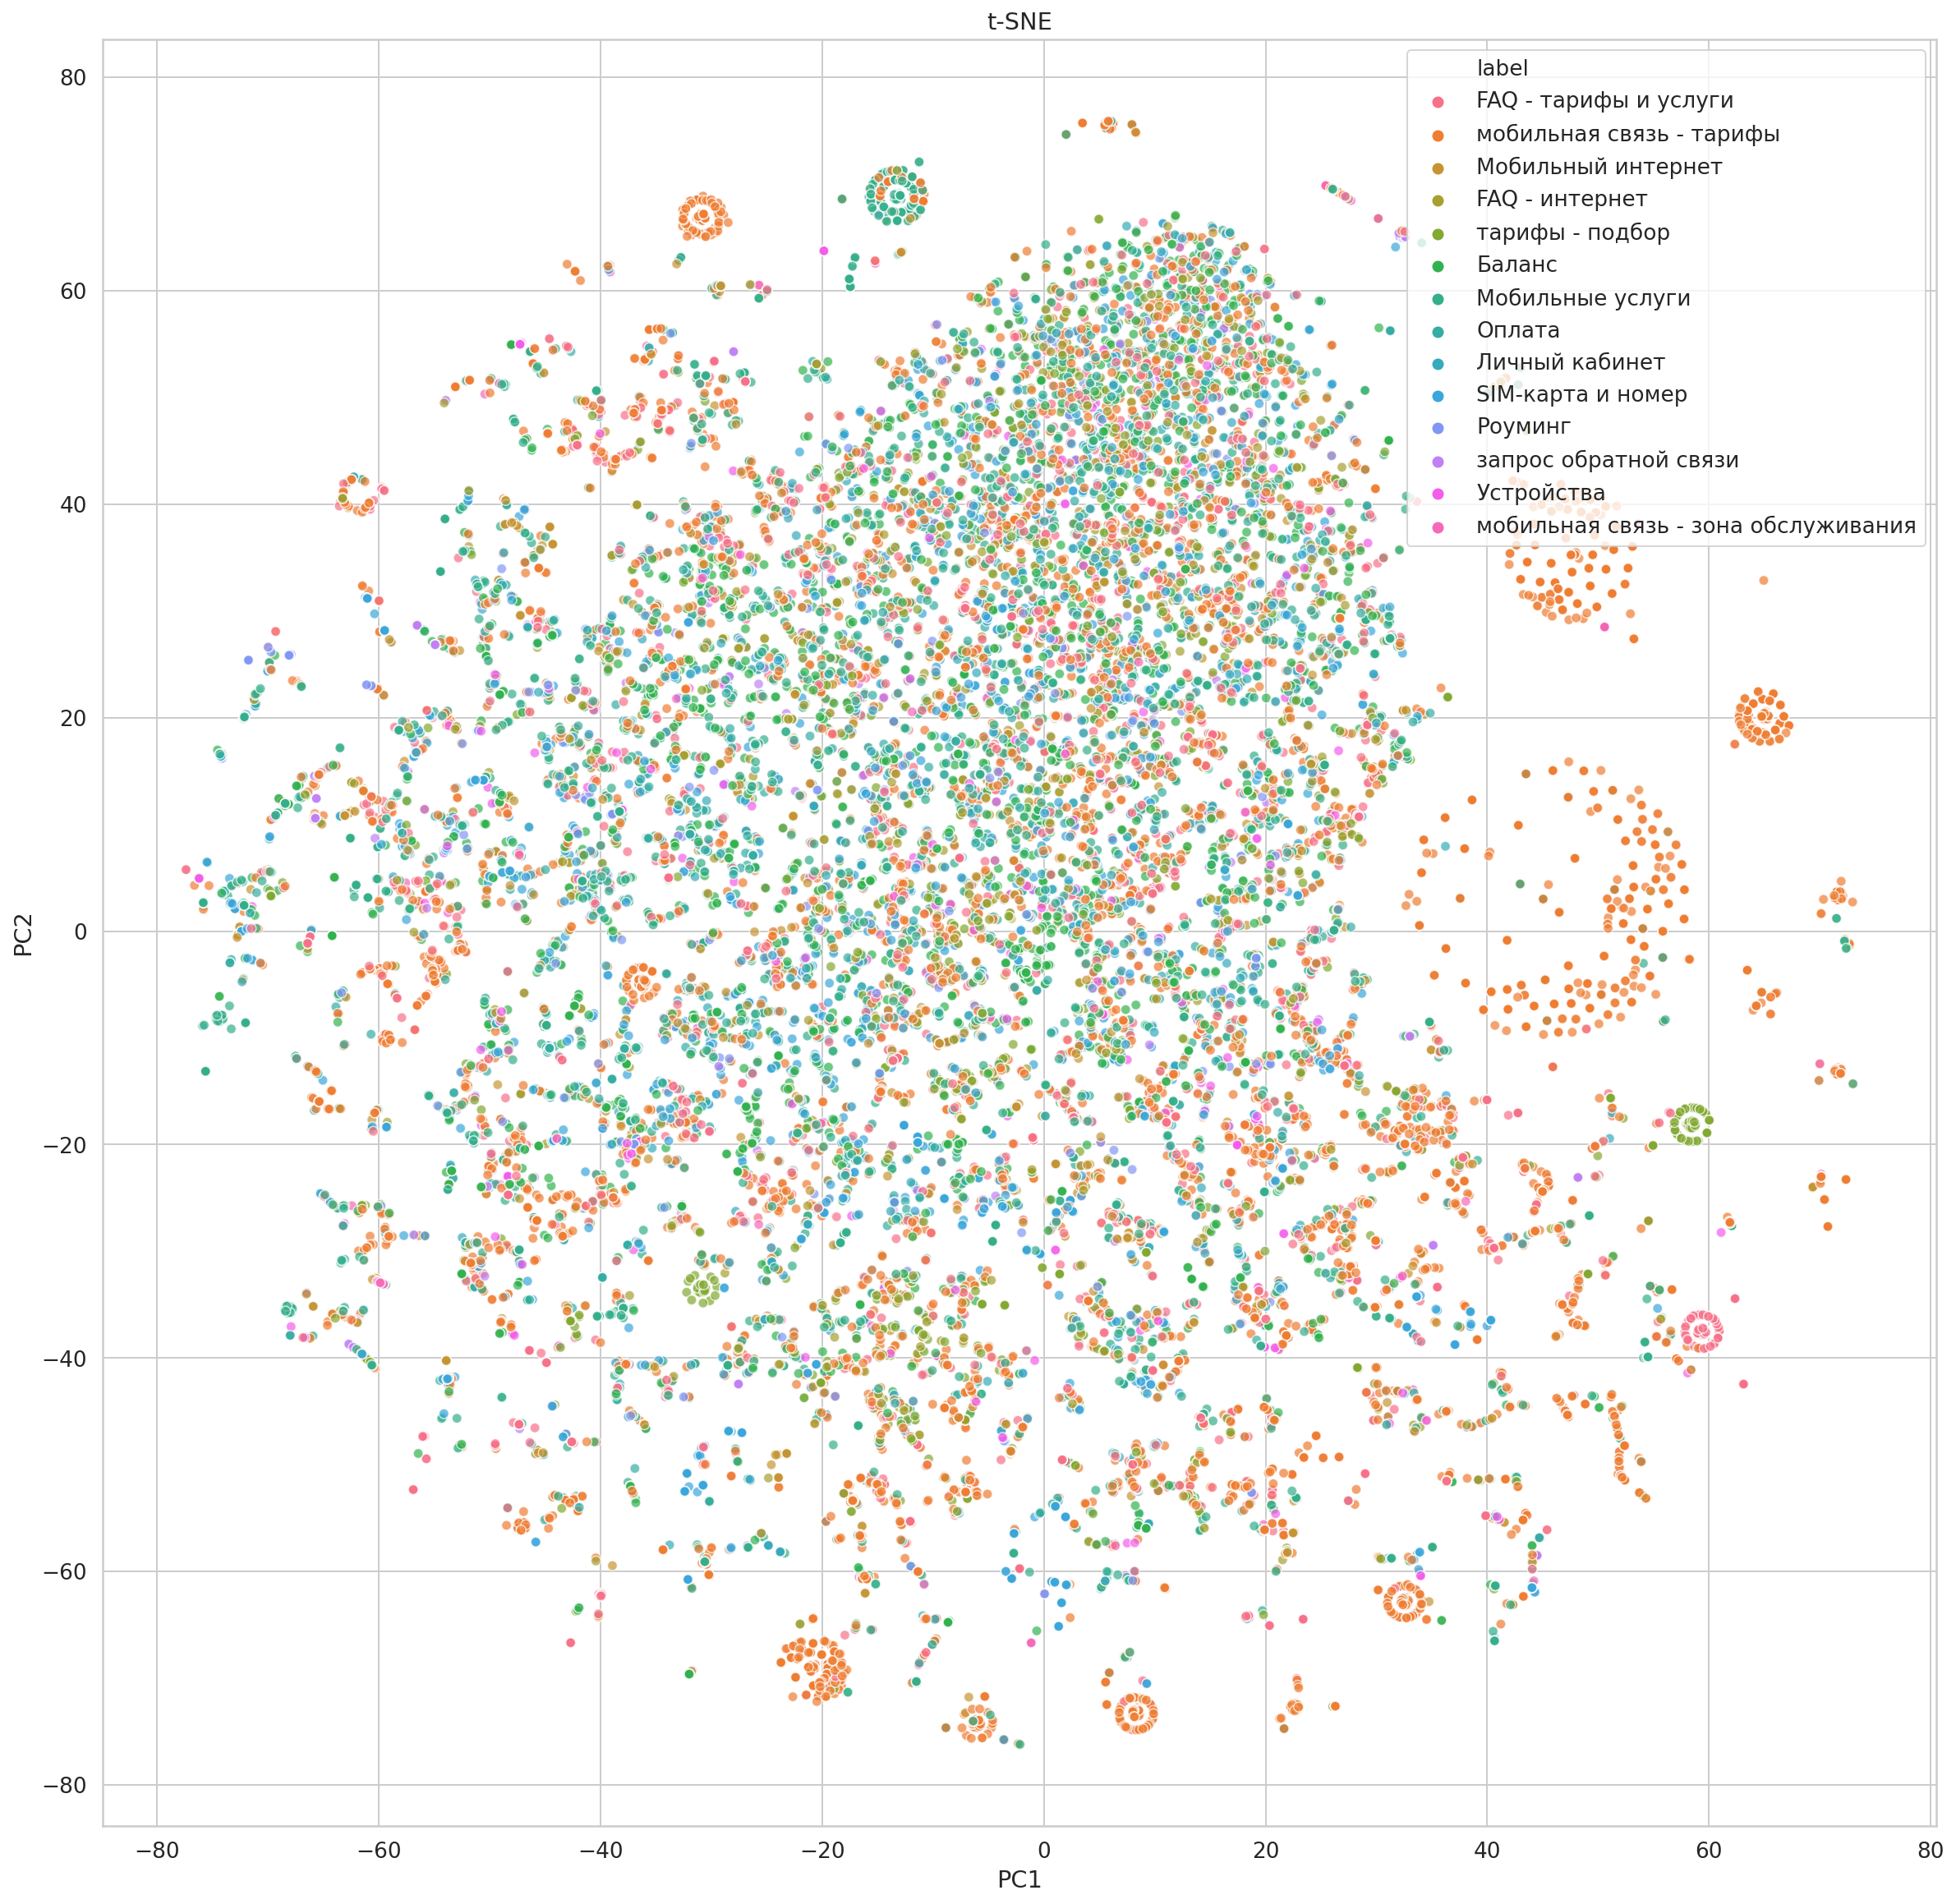

In [18]:
title = "t-SNE"
df_features = pd.DataFrame(data=X_emb,
                     columns=['PC1', 'PC2'])
df_labels = pd.DataFrame(data=df.label.values,
                             columns=['label'])
df_full = pd.concat([df_features, df_labels], axis=1)
df_full = df_full.replace({'label':num_to_class})

plt.figure(figsize=(20,20))
sns.scatterplot(x='PC1',
                y='PC2',
                hue="label", 
                data=df_full,
                alpha=.7).set_title(title);